In [156]:
import os
from enum import Enum
from graphviz import Digraph
from io import BytesIO
import numpy as np

In [13]:
os.chdir("../")

## Parsing DVF

In [85]:
PATH_TO_DVF = "resources/dfa_nfa_proofs.dvf"

In [86]:
FAR_DeciderTypes(11)

<FAR_DeciderTypes.FAR_DFA_NFA: 11>

In [455]:
class FAR_DeciderTypes(Enum):
    FAR_DFA_ONLY = 10
    FAR_DFA_NFA = 11

class FAR_EntryHeader:
    DVF_HEADER_SIZE = 12
    
    def __init__(self, machine_id: int, decider_type: FAR_DeciderTypes, info_length: int):
        self.machine_id = machine_id
        self.decider_type = decider_type
        self.info_length = info_length
        
    def __repr__(self):
        return str(self)
    
    def __str__(self):
        return f"Machine #{self.machine_id}\nDecider {self.decider_type}\nProof length {self.info_length}"
    
    @classmethod
    def from_bytes(cls, entry_bytes: bytes):
        entry_bytes = BytesIO(entry_bytes)
        machine_id = int.from_bytes(entry_bytes.read(4),byteorder="big")
        decider_type = FAR_DeciderTypes(int.from_bytes(entry_bytes.read(4),byteorder="big"))
        info_length = int.from_bytes(entry_bytes.read(4),byteorder="big")
        return cls(machine_id,decider_type,info_length)
    
class FAR_EntryDFANFA:
    def __init__(self, direction_right_to_left: bool, nb_dfa_states: int, nb_nfa_states: int, 
                 dfa_transitions: list[list[int]], nfa_transitions, accept_vector):
        self.direction_right_to_left = direction_right_to_left
        self.nb_dfa_states = nb_dfa_states
        self.nb_nfa_states = nb_nfa_states
        self.dfa_transitions = dfa_transitions[:]
        self.nfa_transitions = nfa_transitions[:]
        self.accept_vector = accept_vector[:]
        self.steady_state = np.zeros(self.accept_vector.shape).astype(bool)
        self.steady_state[0,-1] = True
        
    def __repr__(self):
        return str(self)
    
    def __str__(self):
        return f"Direction right-to-left {self.direction_right_to_left}\n# DFA states {self.nb_dfa_states}\n# NFA states {self.nb_nfa_states}"
    
    def DFA_to_graphviz(self, d: Digraph):
        for i in range(self.nb_dfa_states):
            for r in range(2):
                from_ = str(i)
                to = str(self.dfa_transitions[i][r])
                d.edge(from_, to, label=str(r))
                
    def NFA_i_to_state_name(self,i) -> str:
        if i == self.nb_nfa_states-1:
                state_name = "⊥"
        else:
            dfa_state = i//5
            letter = chr(ord("A")+i%5)
            state_name = str(dfa_state)+letter
        return state_name
    
    def NFA_to_graphviz(self, d: Digraph):
        for i in range(self.nb_nfa_states):
            state_name = self.NFA_i_to_state_name(i)
            d.node(state_name, shape = "doublecircle" 
                   if self.accept_vector[0,i] else "circle")
        for r in range(2):
            for i in range(self.nb_nfa_states):
                state_from = self.NFA_i_to_state_name(i)
                for j in range(self.nb_nfa_states):
                    if self.nfa_transitions[r][i][j]:
                        state_to = self.NFA_i_to_state_name(j)
                        d.edge(state_from,state_to,label=str(r))
    
    def to_graphviz(self):
        d = Digraph()
        self.DFA_to_graphviz(d)
        self.NFA_to_graphviz(d)
        return d
    
    @classmethod
    def from_bytes(cls, entry_bytes: bytes):
        entry_bytes = BytesIO(entry_bytes)
        direction_byte = entry_bytes.read(1)
        direction_byte = int.from_bytes(direction_byte, byteorder="big")
        direction_right_to_left = direction_byte == 1
        nb_dfa_states = int.from_bytes(entry_bytes.read(2),byteorder="big")
        nb_nfa_states = int.from_bytes(entry_bytes.read(2),byteorder="big")
        dfa_transitions = []
        for i in range(nb_dfa_states):
            dfa_transitions.append([int.from_bytes(entry_bytes.read(1),byteorder="big"),
                                    int.from_bytes(entry_bytes.read(1),byteorder="big")])
        
        # Magical formula which gives the number of bytes
        # When padding with x bits with 0s
        # Equivalent to n + 7 // 8
        nb_bytes = (nb_nfa_states + 7) >> 3
        nfa_transitions = []
        for r in range(2):
            the_bytes = entry_bytes.read(nb_nfa_states*nb_bytes)
            nfa_transitions.append(
                np.unpackbits(np.frombuffer(the_bytes, np.uint8, count=nb_nfa_states*nb_bytes)
                              .reshape((nb_nfa_states, nb_bytes)), 1, nb_nfa_states, 'little').astype(bool))
            
        the_bytes = entry_bytes.read(nb_bytes)
        accept_vector =  np.unpackbits(np.frombuffer(the_bytes, np.uint8, count=nb_bytes)
                         .reshape((1,nb_bytes)), 1, nb_nfa_states, 'little').astype(bool)
        
        
        return cls(direction_right_to_left,nb_dfa_states,nb_nfa_states,dfa_transitions,nfa_transitions,accept_vector)

class FAR_DVF:
    def __init__(self, n_entries):
        self.n_entries = n_entries
        
    @classmethod
    def from_file(cls, file_path):
        f = open(file_path,"rb")
        n_entries = int.from_bytes(f.read(4),byteorder="big")

        to_return = cls(n_entries)
        to_return.file_path = file_path
        
        cursor_position = 4
        cursor_positions = []
        i_entry = 0
        while i_entry != n_entries:
            cursor_positions.append(cursor_position)
            header = FAR_EntryHeader.from_bytes(f.read(FAR_EntryHeader.DVF_HEADER_SIZE))
            cursor_position += FAR_EntryHeader.DVF_HEADER_SIZE
            f.read(header.info_length)
            cursor_position += header.info_length
            i_entry += 1
        
        to_return.cursor_positions = cursor_positions
                
        f.close()
        return to_return
    
    def ith_entry(self, i_entry, verbose=False, just_header=False):
        if i_entry < 0 or i_entry >= self.n_entries:
            raise EOFError(f"Entry {i_entry} does not exist. There are {self.n_entries} entries.")
    
        f = open(self.file_path,"rb")
        f.read(self.cursor_positions[i_entry])
        
        header = FAR_EntryHeader.from_bytes(f.read(FAR_EntryHeader.DVF_HEADER_SIZE))
        
        if just_header:
            return header
        
        entry = None
        if header.decider_type == FAR_DeciderTypes.FAR_DFA_NFA:
            entry = FAR_EntryDFANFA.from_bytes(f.read(header.info_length))
        if verbose:
            print(f"Entry {i_entry}")
            print(header)
        
        f.close()
        return header, entry
        
    def __str__(self) -> str:
        return f"{self.n_entries} entries"
    
    def __repr__(self) -> str:
        return str(self)

In [456]:
dvf = FAR_DVF.from_file(PATH_TO_DVF)
dvf

534866 entries

In [425]:
header, entry = dvf.ith_entry(6)
print(header)
print()
print(entry)

Machine #326
Decider FAR_DeciderTypes.FAR_DFA_NFA
Proof length 77

Direction right-to-left True
# DFA states 3
# NFA states 16


In [420]:
entry.direction_right_to_left

False

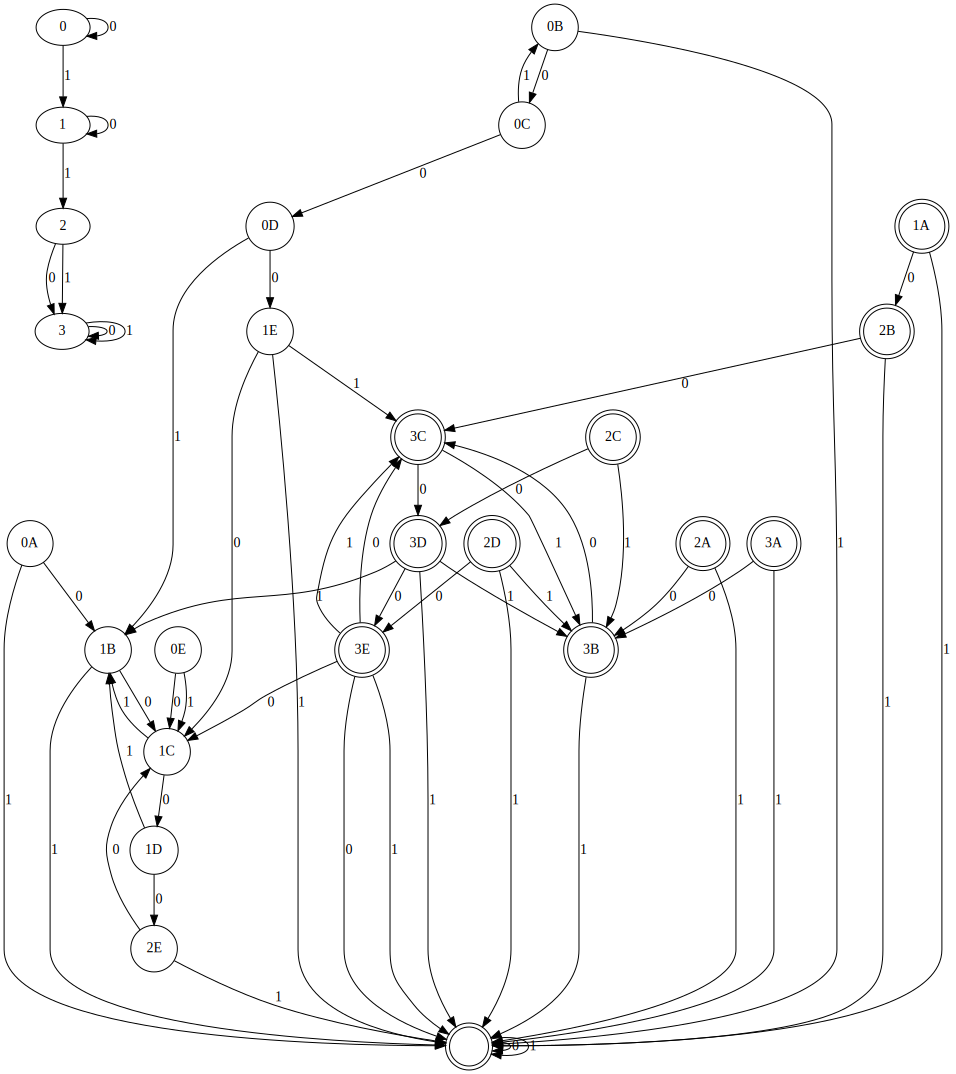

In [488]:
d = Digraph()
entry.DFA_to_graphviz(d)
entry.NFA_to_graphviz(d)
d

In [308]:
def get_machine_i(machine_db_path, i, db_has_header=True):
    with open(machine_db_path, "rb") as f:
        c = 1 if db_has_header else 0
        f.seek(30*(i+c))
        return f.read(30)

In [351]:
header.machine_id

363

In [350]:
entry.nfa_transitions[1].astype(int)[:-1,][2::5,:]

array([[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0]])

In [367]:
def verify_FAR_halting_transition(proof: FAR_EntryDFANFA, from_state, read_symbol):
    # The condition is that for all u q_0 T_u T_f T_r >= s with (f,r) a halting transition
    # In our case, this amount to making sure that NFA states 0f, 1f, etc..., (l-1)f 
    # (with l the number of DFA states), when they read r, reach at least all states of s
    # Here s is \bot, hence we just have to check that reading 0 from those states reaches \bot in all cases
    return proof.nfa_transitions[read_symbol][:-1,][from_state::5,:][:,-1].all()

In [499]:
np.array([[0,1,0,0]]).T @ np.array([[0,0,0,1]])

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [507]:
def verify_FAR_left_transition(proof, from_state, read_symbol, write, goto):
    # The condition is:
    # For all b \in {0,1}
    # R_r >= row_{\delta(i,b)}(M_f)^T row_i(M_t) R_b R_w
    # Which amounts to checking R_b R_w at position "\delta(i,b)f", "it"
    
    for i_dfa_state in range(proof.nb_dfa_states):
        for b in range(2):
            goes_to_dfa_state = proof.dfa_transitions[i_dfa_state][b]
            RbRw = proof.nfa_transitions[b] @ proof.nfa_transitions[write]
            
            i = 5*goes_to_dfa_state + from_state
            j = 5*i_dfa_state + goto
            
            if not (proof.nfa_transitions[read_symbol][i,:] >= RbRw[j, :]).all():
                #print(i_dfa_state, b, write)
                #print(i,j, proof.nfa_transitions[read_symbol][i,j], RbRw[i,j])
                #print(RbRw.astype(int))
                return False
            
    
    return True

In [506]:
verify_FAR_left_transition(entry, 4, 0, 0, 3)

True

In [435]:
def verify_FAR_right_transition(proof, from_state, read_symbol, write, goto):
    # The condition is:
    # R_r >= row_i(M_f)^T row_{\delta(i,w)}(M_t)
    # Which amounts to checking R_r at position "if", "\delta(i,w)t" 
    
    done = set({})
    for i_dfa_state in range(proof.nb_dfa_states):
        goes_to_dfa_state = proof.dfa_transitions[i_dfa_state][write]
        
        if goes_to_dfa_state in done:
            continue
        done.add(goes_to_dfa_state)
        
        nfa_state_i_f = 5*i_dfa_state + from_state
        nfa_state_delta_i_w_t = 5*goes_to_dfa_state + goto
        
        if not proof.nfa_transitions[read_symbol][nfa_state_i_f,nfa_state_delta_i_w_t]:
            return False
        
    
    return True

In [406]:
header

Machine #326
Decider FAR_DeciderTypes.FAR_DFA_NFA
Proof length 77

In [430]:
entry.direction_right_to_left

True

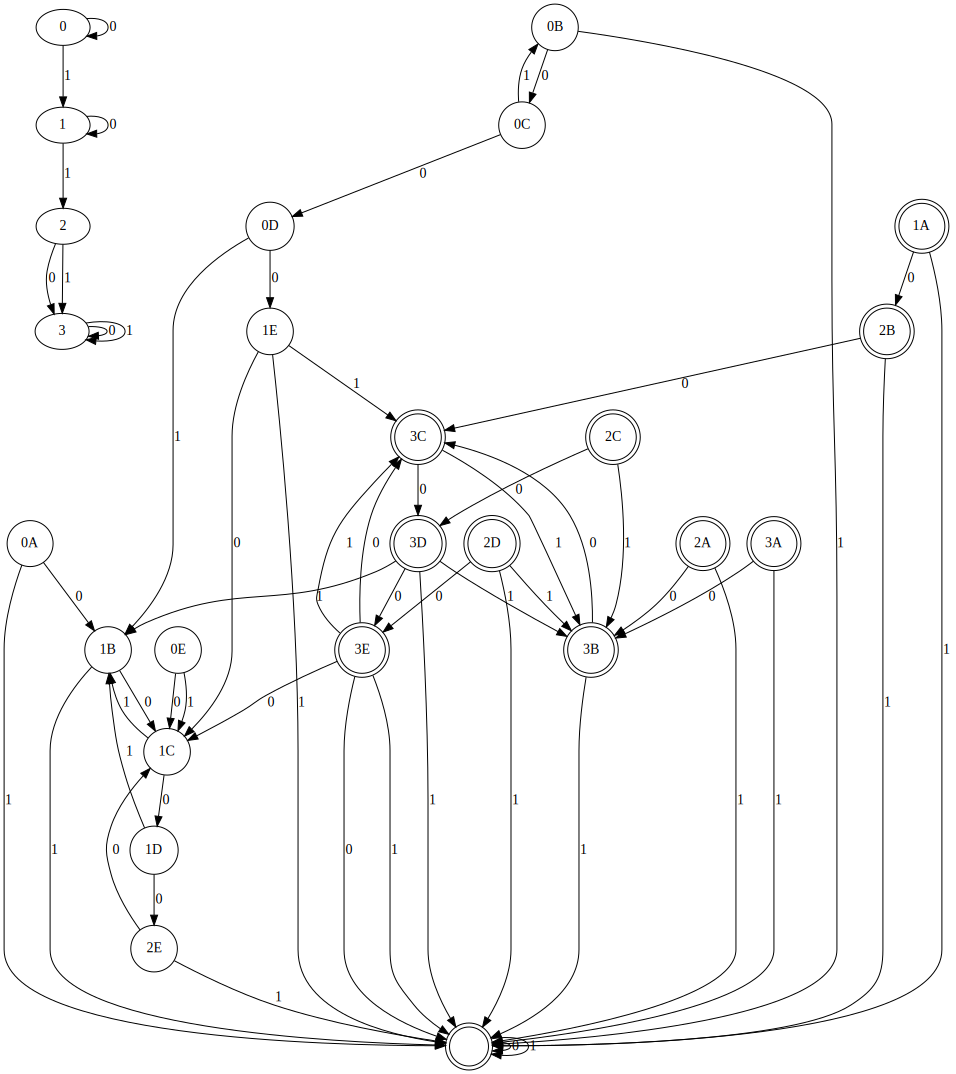

In [500]:
entry.to_graphviz()

In [472]:
def st_name(state):
    return chr(ord("A")+state)

In [474]:
def mt_name(move):
    return "R" if move == 0 else "L"

In [473]:
def transition_name(state,read):
    return st_name(state)+str(read)

In [477]:
def verify_FAR_proof_DFA_NFA(header: FAR_EntryHeader, proof: FAR_EntryDFANFA, verbose = False):
    # Condition 1 (Leading zeros ignored)
    # The DFA's transition function \delta should verify 
    # \delta(0,0) = 0
    if proof.dfa_transitions[0][0] != 0:
        return False, 1
    
    # Condition 2 (Trailing zeros ignored)
    # The NFA's should verify T_0a^T = a^T
    if not (proof.nfa_transitions[0] @ proof.accept_vector.T == proof.accept_vector.T).all():
        return False, 2
    
    # Condition 3 (Steady state is accepting)
    # Here, the steady state is ⊥ (last index)
    if not proof.accept_vector[0,-1]:
        return False, 3
    
    
    # Condition 4 (Steady state is steady)
    # s T_0 >= s
    # s T_1 >= s
    # Here, the steady state is ⊥ (last index)
    # Hence we can simply check sT_0 and sT_1 at position -1,-1
    # And just compute this position thanks to the last columns of T_0 and T_1
    if not ((proof.steady_state @ proof.nfa_transitions[0][:,-1].reshape(entry.nb_nfa_states,1))[0,0] and
            (proof.steady_state @ proof.nfa_transitions[0][:,-1].reshape(entry.nb_nfa_states,1))[0,0]):
        return False, 4
    
    
    # Condition 8 (Initial configuration rejected)
    if proof.accept_vector[0,0]:
        return False, 8
    
    
    # There is one condition to check per machine's transition rule
    M = get_machine_i("../all_5_states_undecided_machines_with_global_header",header.machine_id)
    for from_state in range(5):
        for read_symbol in range(2):
            write, move_to, goto = M[6*from_state + 3*read_symbol:6*from_state + 3*read_symbol+3]
            
            # Symmetrising machine if scan is right to left
            if entry.direction_right_to_left:
                move_to = 1-move_to
            
            goto -= 1
            
            if verbose:
                if goto != -1:
                    print(f"Checking {transition_name(from_state,read_symbol)}: {write}{mt_name(move_to)}{st_name(goto)}") 
                else:
                    print(f"Checking {transition_name(from_state,read_symbol)}: ⊥") 
            # Condition 5: halting transition
            if goto == -1:
                if verbose:
                    print("Checking halt")
                if not verify_FAR_halting_transition(proof, from_state, read_symbol):
                    return False, 4
                
            # Condition 6: left-going transition
            elif move_to == 1:
                if verbose:
                    print("Checking left")
                if not verify_FAR_left_transition(proof, from_state, read_symbol, write, goto):
                    return False, 4
                
            # Condition 7: right-going transition
            elif move_to == 0:
                if verbose:
                    print("Checking right")
                if not verify_FAR_right_transition(proof, from_state, read_symbol, write, goto):
                    return False, 4
                
    
    return True, 0

In [478]:
header

Machine #333
Decider FAR_DeciderTypes.FAR_DFA_NFA
Proof length 142

In [479]:
entry

Direction right-to-left False
# DFA states 4
# NFA states 21

In [480]:
verify_FAR_proof_DFA_NFA(header, entry, True)

Checking A0: 1RB
Checking right
Checking A1: ⊥
Checking halt
Checking B0: 0RC
Checking right
Checking B1: ⊥
Checking halt
Checking C0: 0RD
Checking right
Checking C1: 0RB
Checking right
Checking D0: 1RE
Checking right
Checking D1: 1LE
Checking left
Checking E0: 0LD
Checking left


(False, 4)

In [440]:
entry.direction_right_to_left

True

In [458]:
dvf.ith_entry(9)

(Machine #333
 Decider FAR_DeciderTypes.FAR_DFA_NFA
 Proof length 142,
 Direction right-to-left False
 # DFA states 4
 # NFA states 21)

In [508]:
skip_count = 0
for i_entry in tqdm.tqdm(range(dvf.n_entries)):
    header, entry = dvf.ith_entry(i_entry)
    if header.decider_type != FAR_DeciderTypes.FAR_DFA_NFA:
        skip_count += 1
    verified, error_id = verify_FAR_proof_DFA_NFA(header, entry)
    if not verified:
        print(f"Error {i_entry}, {error_id}")
        break

 10%|███▍                               | 52589/534866 [02:14<20:34, 390.72it/s]


KeyboardInterrupt: 

In [269]:
header, entry = dvf.ith_entry(i_entry)

In [270]:
print(entry)

Direction right-to-left False
# DFA states 3
# NFA states 16


In [273]:
entry.steady_state.shape

(1, 16)

In [274]:
entry.accept_vector.shape

(1, 16)

In [503]:
np.array([[0,1,0,0]]).T@np.array([[0,0,1,0]])@np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])

array([[ 0,  0,  0,  0],
       [ 9, 10, 11, 12],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]])

In [504]:
np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])[2,:]

array([ 9, 10, 11, 12])